In [1]:
import pandas as pd
import math
from datetime import date
import glob
import json
import numpy as np
import nbimporter
import sys
import numpy as np
import traceback
from os.path import exists
from datetime import timedelta

In [2]:
def load_data(file):
    daily = pd.read_csv(file)
    if 'Date' in daily.columns:
        daily['Date'] = pd.to_datetime(daily['Date'])
    else:
        daily['Date'] = pd.to_datetime(daily['Datetime'], utc=True).dt.tz_convert('US/Eastern')
    daily = daily.sort_values(by='Date', ascending=True)
    daily['Day'] = daily['Date'].dt.strftime('%m/%d/%Y')
    daily['Time'] = daily['Date'].dt.strftime('%H:%M')
    daily = daily.dropna().reset_index(drop=True)
    return daily

def load_yahoo_data(file):
    daily = pd.read_csv(file)
    if 'Date' in daily.columns:
        daily['Date'] = pd.to_datetime(daily['Date'])
    else:
        daily['Date'] = pd.to_datetime(daily['Datetime'], utc=True).dt.tz_convert('US/Eastern')
    daily = daily.sort_values(by='Date', ascending=True)
    daily['Day'] = daily['Date'].dt.strftime('%Y-%m-%d')
    daily['Time'] = daily['Date'].dt.strftime('%H:%M')
    daily = daily.dropna().reset_index(drop=True)
    return daily
def load_NKE_data():
    files = ["/Users/partha/Downloads/0-DTE/Stocks/NKE-20Year.csv",
            
            ]
    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
    df = df.drop_duplicates().sort_values(by='Date', ascending=True)
    return df

def load_stock_data(files):
    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
    df = df.drop_duplicates().sort_values(by='Date', ascending=True)
    return df

def load_stocks_data():
    files = ["/Users/partha/Downloads/0-DTE/stocks/GOOG-Dec-16.csv",
#              "/Users/partha/Downloads/0-DTE/indexes/NFLX-Dec-16.csv",
#              "/Users/partha/Downloads/0-DTE/indexes/GOOG-Dec-16.csv"
            ]
    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
        df
    df = df.drop_duplicates().sort_values(by='Date', ascending=True)
    return df
def load_all_5min_spx():
    files = [ 
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-13.csv",
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-16.csv",
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-12.csv",
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-9.csv",
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-8.csv",
            "/Users/partha/Downloads/0-DTE/indexes/SPX-DEC-6.csv",
             "/Users/partha/Downloads/0-DTE/indexes/SPX-DEC-7.csv",
            "/Users/partha/Downloads/0-DTE/indexes/spx-oct-28-snapshot.csv",
        "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-20.csv",
    "/Users/partha/Downloads/0-DTE/indexes/SPX-Dec-19.csv"]

    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
    df = df[df['Day'] > '08/31/2022']
    return df.drop_duplicates().sort_values(by='Date', ascending=True)
# df = load_all_5min_spx()
# df.head()

def load_5min_vix():
    files = [ 
        "/Users/partha/Downloads/0-DTE/indexes/VIX-Dec-9.csv",
        "/Users/partha/Downloads/0-DTE/indexes/VIX-Nov-09.csv",
        "/Users/partha/Downloads/0-DTE/indexes/VIX-Nov-09.csv"
    ]
    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
    df = df[df['Day'] > '08/31/2022']
    return df.drop_duplicates().sort_values(by='Date', ascending=True)
    
def load_annual_data():
    files = ["/Users/partha/Downloads/0-DTE/indexes/SPX-20Year.csv",
            
            ]
    df = pd.DataFrame()
    for file in files:
        print ('Loading file {}'.format(file))
        df = df.append(load_data(file))
    df = df.drop_duplicates().sort_values(by='Date', ascending=True)
    return df



In [37]:
def build_seq(segment, split_size=10):
    
    rge = segment['High'].max() - segment['Low'].min()
    ilist = np.array_split(segment, split_size)
    amap = []
   
    for idf in ilist:
        try:
            idf = idf.reset_index(drop=True)
            s = int((idf[:1]['Open'].min()-segment['Low'].min())*split_size/rge)
            e = int((idf.iloc[-1]['Close'].min()-segment['Low'].min())*split_size/rge)
            if not amap:
                amap.append(s)
            else:    
                amap.append(e)
        except Exception as e:
            #print ("Exception while building Sequence {}".format(e))
            pass    
    return amap


def predict(amap, seq_map, dates=None, times=None):
    lowest = sys.maxsize
    mystack = []
    match_seq = None
    for seq_key in seq_map.keys():
        seq = seq_map[seq_key]
        aseq = seq['Sequence']
        
        if aseq is None:
            continue
            
        if dates is not None:
            end_date = seq['Start Date']
            if end_date in dates: # and seq['Start Time'] == times[dates.index(end_date)]:
                continue
            else:
                pass

        try:
            dist = np.linalg.norm(np.array(aseq)-np.array(amap))
            if dist == 0:
                continue
                
            if dist < lowest:
                lowest = dist
                match_seq = str(aseq)
                mystack.append(seq)
            
        except Exception as e:
            #print (e)
            pass
    prediction = seq_map[match_seq].copy() if seq else {}
    try:
        prediction['Distance'] = lowest
        #prediction['stack'] = mystack
        pass
    except:
        pass
    return prediction


def test_a_segment(asegment, seqmap, split_size=20):
    asegment = asegment.reset_index(drop=True)
    if len(asegment) != split_size:
        print ("Input size and split size doesn't match {} / {}".format(len(asegment), split_size))
        return
    amap = build_seq(asegment, split_size)
    return predict(amap, seqmap)



In [21]:
class TestUnit:
    
    def __init__(self, df, outcome):
        self.unit = df
        self.outcome = outcome
      
    def test_date(self):
        return self.unit.iloc[-1]['Date']
    
    def to_string(self):
        print (self.unit[0]['Date'], self.unit.iloc[-1]['Date'],h)
        
def getTestUnits(sym, window=20, horizon=10, backtest_days=50):
    df = load_yahoo_data('/Users/partha/Downloads/0-DTE/Stocks/sp500/daily-stocks/{}.csv'.format(sym))
    df = df[-backtest_days:]
    units = []
    
    for i in range(0, len(df)-(window + horizon - 1)):
        adf = df[i:i+window]
        hdf = df[i+window:i+window+horizon]
        h = 1 if hdf.iloc[-1]['Close'] > adf.iloc[-1]['Close'] else -1
        units.append(TestUnit(adf, h))
    return units

    

In [52]:
def run_predictions(pdf, match, horizon):
    end = match['End Date']
    pdf = pdf[pdf['Date'] >= end]
    return 1 if pdf.iloc[horizon]['Close'] > pdf.iloc[0]['Close'] else -1

def predict_now(symbols, horizon=10):
    futures = []
    for sym in symbols:
        try:
            model_file = '/Users/partha/Downloads/0-DTE/Stocks/sp500-models-cleaned/{}.json'.format(sym)
            pdf = load_yahoo_data('/Users/partha/Downloads/0-DTE/Stocks/sp500/{}-20Year.csv'.format(sym))
            model = json.loads(open(model_file).read())
            df = load_yahoo_data('/Users/partha/Downloads/0-DTE/Stocks/sp500/daily-stocks/{}.csv'.format(sym))
            match = test_a_segment(df[-20:], model, 20)
            prediction = run_predictions(pdf, match, horizon)
            futures.append({'S': sym, 'F': prediction})
        except Exception as e:
            pass
    return pd.DataFrame(futures)

predict_now(['ABBV', 'AAPL'])


,S,F
0,ABBV,1


In [45]:
def run_tests(horizon=10):
    predictions = pd.DataFrame()
    symbols = pd.read_csv('Symbols.csv')['Symbol']
    tot = len(symbols)
    count = 0
    for sym in symbols:
        try:
            count += 1
            model_file = '/Users/partha/Downloads/0-DTE/Stocks/sp500-models-cleaned/{}.json'.format(sym)
            pdf = load_yahoo_data('/Users/partha/Downloads/0-DTE/Stocks/sp500/{}-20Year.csv'.format(sym))
            model = json.loads(open(model_file).read())
            units = getTestUnits(sym)
            preds = []
            for unit in units:
                try:
                    match = test_a_segment(unit.unit, model, 20)
                    prediction = run_predictions(pdf, match, horizon)
                    r = {'S': sym, 'D':unit.test_date(), 'A':unit.outcome, 'P': prediction}
                    preds.append(r)
                except Exception as e:
                    pass
            preds = pd.DataFrame(preds)
            preds['O'] = (preds.A + preds.P)/2
            preds['D'] = preds['D'].dt.strftime('%Y-%m-%d')
            predictions = predictions.append(preds)
            print ('{}/{} {} {}'.format(count, tot, sym, len(preds[preds['O'] != 0.0])/len(preds)))
        except:
            pass
    return predictions

def run_p_profile(df):
    pdf = []
    for key, gr in df.groupby(['S']):
        pdf.append({'S': key, 'Rate': len(gr[gr['A'] == gr['P']])/len(gr)})
    pdf = pd.DataFrame(pdf).sort_values(by=['Rate'], ascending=False)
    return pdf



In [31]:
odf = run_tests()
p_score = run_p_profile(odf)

1/505 MMM 0.5238095238095238
2/505 AOS 0.38095238095238093
3/505 ABT 0.47619047619047616
4/505 ABBV 0.8
5/505 ABMD 0.7619047619047619
6/505 ACN 0.6190476190476191
7/505 ATVI 0.5238095238095238
9/505 ADBE 0.38095238095238093
10/505 AAP 0.5714285714285714
11/505 AMD 0.3333333333333333
12/505 AES 0.3333333333333333
13/505 AFL 0.7619047619047619
14/505 A 0.3333333333333333
15/505 APD 0.6190476190476191
16/505 AKAM 0.3333333333333333
17/505 ALK 0.3333333333333333
18/505 ALB 0.5238095238095238
19/505 ARE 0.6666666666666666
20/505 ALGN 0.6666666666666666
22/505 LNT 0.47619047619047616
23/505 ALL 0.5238095238095238
24/505 GOOGL 0.5714285714285714
25/505 GOOG 0.47619047619047616
26/505 MO 0.5714285714285714
27/505 AMZN 0.6190476190476191
29/505 AEE 0.6190476190476191
30/505 AAL 0.38095238095238093
31/505 AEP 0.6190476190476191
32/505 AXP 0.5238095238095238
33/505 AIG 0.5238095238095238
34/505 AMT 0.47619047619047616
36/505 AMP 0.6190476190476191
37/505 ABC 0.7142857142857143
38/505 AME 0.619047

Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequen

Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequence float division by zero
Exception while building Sequen

309/505 MRK 0.3333333333333333
310/505 MET 0.38095238095238093
311/505 MTD 0.47619047619047616
312/505 MGM 0.47619047619047616
313/505 MCHP 0.5238095238095238
314/505 MU 0.42857142857142855
315/505 MSFT 0.47619047619047616
316/505 MAA 0.38095238095238093
318/505 MHK 0.42857142857142855
319/505 TAP 0.38095238095238093
320/505 MDLZ 0.6190476190476191
321/505 MPWR 0.2857142857142857
322/505 MNST 0.38095238095238093
323/505 MCO 0.38095238095238093
324/505 MS 0.42857142857142855
325/505 MSI 0.5714285714285714
327/505 NDAQ 0.5238095238095238
328/505 NTAP 0.3333333333333333
329/505 NFLX 0.6190476190476191
330/505 NWL 0.47619047619047616
331/505 NEM 0.47619047619047616
334/505 NEE 0.3333333333333333
336/505 NKE 0.7142857142857143
337/505 NI 0.5238095238095238
338/505 NSC 0.6666666666666666
339/505 NTRS 0.6190476190476191
340/505 NOC 0.6190476190476191
341/505 NLOK 0.6666666666666666
343/505 NRG 0.5714285714285714
344/505 NUE 0.19047619047619047
345/505 NVDA 0.47619047619047616
346/505 NVR 0.57

In [34]:
from datetime import datetime
def dashboard(N=75):
    entries = []
    try:
        for s in p_score['S']:
            entry = {
                'S' : s
            }
            entry['O%'] = round(p_score[p_score['S'] == s]['Rate'].values[0], 2) * 100
            for col in odf['D'].unique():
                try:
                    day = str(datetime.strptime(col, "%Y-%m-%d").month) + "/" + str(datetime.strptime(col, "%Y-%m-%d").day)
                    entry[day] = odf[(odf['D'] == col) & (odf['S'] == s)].iloc[0]['O']
                except Exception as e:
                    pass

            entries.append(entry)
    except:
        pass
    return pd.DataFrame(entries)
dbdf = dashboard().sort_values(by='O%', ascending=False)     



,S,O%,11/15,11/16,11/17,11/18,11/21,11/22,11/23,11/25,...,12/6,12/7,12/8,12/9,12/12,12/13,12/14,11/10,11/11,11/14
0,PG,81.0,0.00,1.00,1.00,1.00,1.0,1.00,0.00,1.00,...,1.00,1.00,1.00,1.00,1.00,-1.00,0.00,NaN,NaN,NaN
1,WU,81.0,1.00,1.00,1.00,1.00,-1.0,-1.00,-1.00,0.00,...,-1.00,1.00,-1.00,0.00,0.00,0.00,1.00,NaN,NaN,NaN
2,ABBV,80.0,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,...,0.00,-1.00,0.00,1.00,NaN,-1.00,-1.00,NaN,NaN,NaN
3,LVS,76.0,1.00,1.00,0.00,0.00,1.0,1.00,1.00,0.00,...,-1.00,-1.00,0.00,-1.00,1.00,-1.00,-1.00,NaN,NaN,NaN
4,LOW,76.0,1.00,1.00,1.00,-1.00,-1.0,-1.00,-1.00,-1.00,...,0.00,-1.00,0.00,0.00,-1.00,-1.00,-1.00,NaN,NaN,NaN
5,HUM,76.0,1.00,1.00,0.00,1.00,1.0,1.00,1.00,-1.00,...,-1.00,-1.00,0.00,0.00,0.00,-1.00,-1.00,NaN,NaN,NaN
6,AFL,76.0,1.00,1.00,0.00,1.00,-1.0,-1.00,-1.00,-1.00,...,-1.00,0.00,1.00,1.00,1.00,0.00,0.00,NaN,NaN,NaN
7,BXP,76.0,-1.00,1.00,1.00,0.00,0.0,-1.00,0.00,-1.00,...,0.00,1.00,1.00,0.00,1.00,-1.00,-1.00,NaN,NaN,NaN
8,ABMD,76.0,1.00,1.00,1.00,1.00,1.0,0.00,1.00,1.00,...,1.00,1.00,0.00,0.00,NaN,NaN,NaN,1.0,1.0,1.0
9,COO,71.0,0.00,1.00,1.00,0.00,0.0,1.00,1.00,-1.00,...,1.00,1.00,1.00,0.00,1.00,0.00,1.00,NaN,NaN,NaN


In [63]:
mdb = dbdf[:50]
now = predict_now(mdb['S'].tolist())
mdb = mdb.merge(now, on='S')
totals = {}

for c in dbdf.columns:
    if c == 'S':
        totals[c] = 'Average'
    else:
        totals[c] = len(mdb[mdb[c] != 0.0])/len(mdb)
mdb = mdb.append(totals, ignore_index=True)
mdb.iloc[:,:]

,S,O%,11/15,11/16,11/17,11/18,11/21,11/22,11/23,11/25,...,12/7,12/8,12/9,12/12,12/13,12/14,11/10,11/11,11/14,F
0,PG,81.0,0.00,1.00,1.00,1.00,1.0,1.00,0.00,1.00,...,1.00,1.00,1.00,1.00,-1.00,0.00,NaN,NaN,NaN,-1.0
1,WU,81.0,1.00,1.00,1.00,1.00,-1.0,-1.00,-1.00,0.00,...,1.00,-1.00,0.00,0.00,0.00,1.00,NaN,NaN,NaN,-1.0
2,ABBV,80.0,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,...,-1.00,0.00,1.00,NaN,-1.00,-1.00,NaN,NaN,NaN,1.0
3,LVS,76.0,1.00,1.00,0.00,0.00,1.0,1.00,1.00,0.00,...,-1.00,0.00,-1.00,1.00,-1.00,-1.00,NaN,NaN,NaN,1.0
4,LOW,76.0,1.00,1.00,1.00,-1.00,-1.0,-1.00,-1.00,-1.00,...,-1.00,0.00,0.00,-1.00,-1.00,-1.00,NaN,NaN,NaN,-1.0
5,HUM,76.0,1.00,1.00,0.00,1.00,1.0,1.00,1.00,-1.00,...,-1.00,0.00,0.00,0.00,-1.00,-1.00,NaN,NaN,NaN,-1.0
6,AFL,76.0,1.00,1.00,0.00,1.00,-1.0,-1.00,-1.00,-1.00,...,0.00,1.00,1.00,1.00,0.00,0.00,NaN,NaN,NaN,1.0
7,BXP,76.0,-1.00,1.00,1.00,0.00,0.0,-1.00,0.00,-1.00,...,1.00,1.00,0.00,1.00,-1.00,-1.00,NaN,NaN,NaN,-1.0
8,ABMD,76.0,1.00,1.00,1.00,1.00,1.0,0.00,1.00,1.00,...,1.00,0.00,0.00,NaN,NaN,NaN,1.0,1.0,1.0,1.0
9,COO,71.0,0.00,1.00,1.00,0.00,0.0,1.00,1.00,-1.00,...,1.00,1.00,0.00,1.00,0.00,1.00,NaN,NaN,NaN,-1.0


In [64]:
def getHourlyTestUnits(window=20, horizon=10, backtest_days=50):
    df = load_data('/Users/partha/Downloads/0-DTE/indexes/Hourly-SPX-Jan-01.csv')
    df = df[-backtest_days:]
    units = []
    
    for i in range(0, len(df)-(window + horizon - 1)):
        adf = df[i:i+window]
        hdf = df[i+window:i+window+horizon]
        h = 1 if hdf.iloc[-1]['Close'] > adf.iloc[-1]['Close'] else -1
        units.append(TestUnit(adf, h))
    return units

def run_Hourly_tests(horizon=10):
    predictions = pd.DataFrame()
    try:
            
            model_file = '/Users/partha/Downloads/0-DTE/models/SPX-hourly.json'
            pdf = load_data('/Users/partha/Downloads/0-DTE/indexes/Hourly-SPX-Jan-01.csv')
            model = json.loads(open(model_file).read())
            units = getTestUnits(sym)
            preds = []
            for unit in units:
                try:
                    match = test_a_segment(unit.unit, model, 20)
                    prediction = run_predictions(pdf, match, horizon)
                    r = {'S': sym, 'D':unit.test_date(), 'A':unit.outcome, 'P': prediction}
                    preds.append(r)
                except Exception as e:
                    pass
            preds = pd.DataFrame(preds)
            preds['O'] = (preds.A + preds.P)/2
            preds['D'] = preds['D'].dt.strftime('%Y-%m-%d')
            predictions = predictions.append(preds)
            print ('{}/{} {} {}'.format(count, tot, sym, len(preds[preds['O'] != 0.0])/len(preds)))
        except:
            pass
    return predictions

def run_p_profile(df):
    pdf = []
    for key, gr in df.groupby(['S']):
        pdf.append({'S': key, 'Rate': len(gr[gr['A'] == gr['P']])/len(gr)})
    pdf = pd.DataFrame(pdf).sort_values(by=['Rate'], ascending=False)
    return pdf


,S,O%,11/15,11/16,11/17,11/18,11/21,11/22,11/23,11/25,...,12/6,12/7,12/8,12/9,12/12,12/13,12/14,11/10,11/11,11/14


In [72]:
#run_p_profile(stockwise500)
pp_3M = run_p_profile(stockwise417[stockwise417['D'] >= '2022-07-01'])
#pp_3M.to_csv('Top-N-3Month-Stocks-With-Good-Predictability.csv')
#stockwise500[stockwise500['D'] >= '2022-11-01']
pp_3M

,S,Rate
407,YUM,0.672897
205,JPM,0.654206
126,EL,0.654206
49,BEN,0.635514
113,DRI,0.635514
...,...,...
221,LKQ,0.373832
228,LUMN,0.364486
32,AOS,0.364486
104,DGX,0.355140


In [55]:
pp_3M

,S,Rate
32,PG,0.656250
2,ADBE,0.640625
31,PFE,0.625000
19,JPM,0.609375
20,KO,0.593750
34,TMO,0.593750
15,GOOGL,0.578125
17,HON,0.578125
0,ABT,0.578125
16,HD,0.562500


In [104]:
pp = run_p_profile(stockwise417)
pp1 = pp.merge(pp_1M, on='S').merge(pp_3M, on='S').reset_index().rename(columns={'Rate_x': 'All Time', 'Rate': '3 Month', 'Rate_y': '1 Month' })
pp1 = pp1.sort_values(by=['1 Month'], ascending=False)

In [105]:
pp1[:50], pp1[pp1['S'] == 'VRTX']

(     index     S  All Time   1 Month   3 Month
 1        1   YUM     0.620  0.909091  0.672897
 213    213  ABMD     0.500  0.909091  0.542056
 146    146    PG     0.520  0.863636  0.579439
 234    234   TFX     0.495  0.863636  0.514019
 257    257   AVY     0.485  0.818182  0.588785
 143    143   PLD     0.520  0.772727  0.598131
 18      18   SHW     0.575  0.772727  0.551402
 352    352  REGN     0.455  0.772727  0.504673
 134    134   IBM     0.525  0.772727  0.542056
 100    100   PNC     0.535  0.772727  0.532710
 53      53   ROP     0.550  0.772727  0.551402
 268    268  CBRE     0.485  0.772727  0.542056
 83      83   CCL     0.540  0.772727  0.551402
 5        5   ETR     0.595  0.772727  0.598131
 42      42   MOS     0.560  0.727273  0.560748
 141    141  LDOS     0.520  0.727273  0.570093
 136    136   HUM     0.520  0.727273  0.485981
 296    296   ARE     0.475  0.727273  0.514019
 347    347  LRCX     0.460  0.727273  0.514019
 196    196    WU     0.505  0.727273  0

In [146]:
from PIL import Image, ImageDraw
im = Image.new('RGB', (500, 300), (128, 128, 128))
draw = ImageDraw.Draw(im)

In [109]:
stockwise417[(stockwise417['D'] >= '2022-09-01') & (stockwise417['A'] == -1) & (stockwise417['S'] == 'PG')  & (stockwise417['A'] == stockwise417['P'])]

,S,D,A,P,A-Date0,A-Date1
136,PG,2022-09-01,-1,-1,2022-09-01,2022-09-16
141,PG,2022-09-09,-1,-1,2022-09-09,2022-09-23
142,PG,2022-09-12,-1,-1,2022-09-12,2022-09-26
143,PG,2022-09-13,-1,-1,2022-09-13,2022-09-27
144,PG,2022-09-14,-1,-1,2022-09-14,2022-09-28
145,PG,2022-09-15,-1,-1,2022-09-15,2022-09-29
148,PG,2022-09-20,-1,-1,2022-09-20,2022-10-04
151,PG,2022-09-23,-1,-1,2022-09-23,2022-10-07
152,PG,2022-09-26,-1,-1,2022-09-26,2022-10-10
153,PG,2022-09-27,-1,-1,2022-09-27,2022-10-11


In [152]:
stockwise.loc[stockwise['A'] == stockwise['P'], 'Result'] = 1
stockwise.loc[stockwise['A'] != stockwise['P'], 'Result'] = 0
stockwise['Month'] = stockwise.D.dt.month
# stockwise50 = pd.DataFrame(stockwise).sort_values(by='P',ascending=False)
# stockwise50

In [164]:
agg1 = stockwise[stockwise['Result'] == 1].groupby(['S','Month'])['Result'].sum().reset_index()
agg2 = stockwise[stockwise['Result'] == 0].groupby(['S','Month'])['Result'].count().reset_index()

In [144]:
count = []
alltrue = 0
allfalse = 0
Maxtrue = 0
allups = dict()

#stocks = ['EL','ABMD','TFX','FE','PG', 'BEN','YUM','ETR','CE','GOOGL','VRTX']
stocks = ['ETR', 'YUM', 'FE']
for s in stocks:
    allups[s] = 0
for d in stockwise417['D'].unique():
    l = stockwise417[(stockwise417['A'] == stockwise417['P']) & \
                 (stockwise417['D'] == d) & \
                 (stockwise417['A'] == 1) & \
                 (stockwise417['S'].isin(stocks))]
    for s in l['S']:
        allups[s] += 1
    ct = len(l) 
    if ct == len(stocks):
        alltrue += 1
    elif ct == 0:
        allfalse += 1
    if ct >= Maxtrue:
        Maxtrue = ct
    count.append(ct)
    
print ("{} {} {}".format(count, alltrue, allfalse, Maxtrue))
print (allups)
count = pd.Series(count)
for i in range(1, max(count)+1):
    ij = 0
    for j in range(1, i+1):
        ij += len(count[count == j])
        print (ij)
    print (" {} or less: {}".format(i, ij/len(count)))

[2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 0, 1, 0, 0, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 3, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 3, 3, 3, 3, 3, 1, 3, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 1, 1, 2, 2, 3, 3, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 3, 2, 3, 2, 2, 1, 1, 2, 2, 3, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 1, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 3, 3, 2, 3, 3, 3, 2, 1, 1, 2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 3, 3, 1, 1, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 3, 0, 3, 2] 30 62
{'ETR': 94, 'YUM': 86, 'FE': 75}
51
 1 or less: 0.255
51
108
 2 or less: 0.54
51
108
138
 3 or less: 0.69


In [127]:
agg1[agg1['S'] == 'HD']['Result'].plot(kind='bar')

NameError: name 'agg1' is not defined

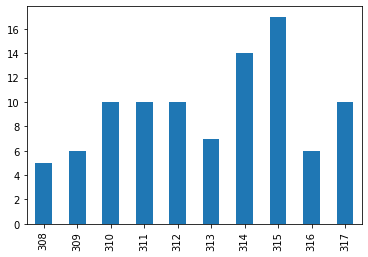

In [180]:
agg2[agg2['S'] == 'NVDA']['Result'].plot(kind='bar')

In [173]:
agg3 = agg1.groupby('S')['Result'].sum().reset_index()

In [174]:
agg3.sort_values(by=['Result'], ascending=False)

,S,Result
15,GOOGL,125
25,MRK,117
14,GOOG,117
34,TMO,117
19,JPM,114
3,AMGN,112
18,JNJ,108
24,MCD,108
2,ADBE,106
17,HON,106


In [177]:
len(stockwise[stockwise['S'] == 'GOOGL'])

200

In [178]:
125/200

0.625

In [186]:
tp = len(stockwise[(stockwise['Result'] == 1) & (stockwise['A'] == 5) & (stockwise['S'] == 'NVDA')])
fp = len(stockwise[(stockwise['Result'] == 1) & (stockwise['A'] == -5) & (stockwise['S'] == 'NVDA')])
tp/(tp+fp)

0.5714285714285714

In [189]:
tn = len(stockwise[(stockwise['Result'] == 1) & (stockwise['A'] == -5) & (stockwise['S'] == 'NVDA')])
fn = len(stockwise[(stockwise['Result'] == 1) & (stockwise['A'] == 5) & (stockwise['S'] == 'NVDA')])
tn/(tn+fn)

0.42857142857142855

In [194]:
sym = 'NVDA'
df = load_yahoo_data('/Users/partha/Downloads/0-DTE/Stocks/sp500/{}-20Year.csv'.format(sym))
test_df = df[-20:]
            #print ("{} {}".format(type(test_df), len(test_df)))
model = json.loads(open('/Users/partha/Downloads/0-DTE/Stocks/sp500-models-cleaned/{}.json'.format(sym)).read())
match = test_a_segment(date, test_df, model, 20)
match

{'Sequence': [0, 2, 3, 7, 6, 6, 6, 9, 9, 9, 9, 8, 11, 12, 15, 17, 10, 8, 5, 9],
 'Start date': '2020-08-12',
 'End Date': '2020-09-09',
 'Start Time': '00:00',
 'End Time': '00:00',
 'Distance': 11.269427669584644}